___

<a href='http://www.pieriandata.com'><img src='../Pierian_Data_Logo.png'/></a>
___
<center><em>Copyright Pierian Data</em></center>
<center><em>For more information, visit us at <a href='http://www.pieriandata.com'>www.pieriandata.com</a></em></center>

# ARMA(p,q) and ARIMA(p,d,q)
# Autoregressive Moving Averages
This section covers <em>Autoregressive Moving Averages</em> (ARMA) and <em>Autoregressive Integrated Moving Averages</em> (ARIMA).

Recall that an <strong>AR(1)</strong> model follows the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \varepsilon_{t}$

while an <strong>MA(1)</strong> model follows the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = \mu + \theta_{1}\varepsilon_{t-1} + \varepsilon_{t}$

where $c$ is a constant, $\mu$ is the expectation of $y_{t}$ (often assumed to be zero), $\phi_1$ (phi-sub-one) is the AR lag coefficient, $\theta_1$ (theta-sub-one) is the MA lag coefficient, and $\varepsilon$ (epsilon) is white noise.

An <strong>ARMA(1,1)</strong> model therefore follows

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \theta_{1}\varepsilon_{t-1} + \varepsilon_{t}$

ARMA models can be used on stationary datasets.

For non-stationary datasets with a trend component, ARIMA models apply a differencing coefficient as well.

<div class="alert alert-info"><h3>Related Functions:</h3>
<tt><strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARMA.html'>arima_model.ARMA</a></strong><font color=black>(endog, order[, exog, …])</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Autoregressive Moving Average ARMA(p,q) model<br>
<strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARMAResults.html'>arima_model.ARMAResults</a></strong><font color=black>(model, params[, …])</font>&nbsp;&nbsp;&nbsp;Class to hold results from fitting an ARMA model<br>
<strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMA.html'>arima_model.ARIMA</a></strong><font color=black>(endog, order[, exog, …])</font>&nbsp;&nbsp;&nbsp;&nbsp;Autoregressive Integrated Moving Average ARIMA(p,d,q) model<br>
<strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMAResults.html'>arima_model.ARIMAResults</a></strong><font color=black>(model, params[, …])</font>&nbsp;&nbsp;Class to hold results from fitting an ARIMA model<br>	
<strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.kalmanf.kalmanfilter.KalmanFilter.html'>kalmanf.kalmanfilter.KalmanFilter</a></strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Kalman Filter code intended for use with the ARMA model</tt>

<h3>For Further Reading:</h3>
<strong>
<a href='https://en.wikipedia.org/wiki/Autoregressive%E2%80%93moving-average_model'>Wikipedia</a></strong>&nbsp;&nbsp;<font color=black>Autoregressive–moving-average model</font><br>
<strong>
<a href='https://otexts.com/fpp2/non-seasonal-arima.html'>Forecasting: Principles and Practice</a></strong>&nbsp;&nbsp;<font color=black>Non-seasonal ARIMA models</font></div>

## Perform standard imports and load datasets

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load datasets
df1 = pd.read_csv('../Data/DailyTotalFemaleBirths.csv',index_col='Date',parse_dates=True)
df1.index.freq = 'D'
df1 = df1[:120]  # we only want the first four months

df2 = pd.read_csv('../Data/TradeInventories.csv',index_col='Date',parse_dates=True)
df2.index.freq='MS'

## Automate the augmented Dickey-Fuller Test
Since we'll be using it a lot to determine if an incoming time series is stationary, let's write a function that performs the augmented Dickey-Fuller Test.

In [3]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

___
## Autoregressive Moving Average - ARMA(p,q)
In this first section we'll look at a stationary dataset, determine (p,q) orders, and run a forecasting ARMA model fit to the data. In practice it's rare to find stationary data with no trend or seasonal component, but the first four months of the <em>Daily Total Female Births</em> dataset should work for our purposes.
### Plot the source data

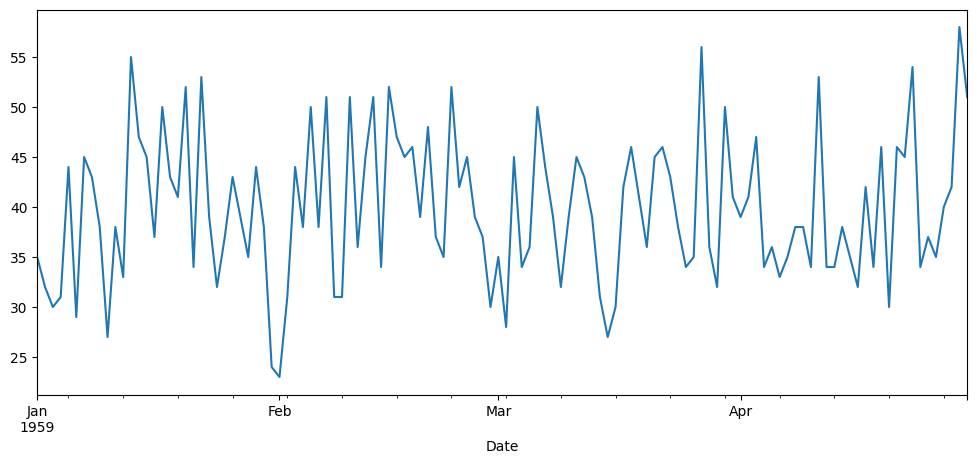

In [2]:
df1['Births'].plot(figsize=(12,5));

### Run the augmented Dickey-Fuller Test to confirm stationarity

In [4]:
adf_test(df1['Births'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -9.855384e+00
p-value                 4.373545e-17
# lags used             0.000000e+00
# observations          1.190000e+02
critical value (1%)    -3.486535e+00
critical value (5%)    -2.886151e+00
critical value (10%)   -2.579896e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


### Determine the (p,q) ARMA Orders using <tt>pmdarima.auto_arima</tt>
This tool should give just $p$ and $q$ value recommendations for this dataset.

In [11]:
auto_model = auto_arima(df1['Births'],seasonal=False)

In [12]:
print(auto_model.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  120
Model:                        SARIMAX   Log Likelihood                -409.745
Date:                Fri, 04 Oct 2024   AIC                            823.489
Time:                        08:59:32   BIC                            829.064
Sample:                    01-01-1959   HQIC                           825.753
                         - 04-30-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     39.7833      0.687     57.896      0.000      38.437      41.130
sigma2        54.1197      8.319      6.506      0.000      37.815      70.424
Ljung-Box (L1) (Q):                   0.85   Jarque-

In [13]:
# Extract p, d, q from the fitted model
p, d, q = auto_model.order
print(f"AR (p): {p}, Differencing (d): {d}, MA (q): {q}")

AR (p): 0, Differencing (d): 0, MA (q): 0


### Split the data into train/test sets
As a general rule you should set the length of your test set equal to your intended forecast size. For this dataset we'll attempt a 1-month forecast.

In [6]:
# Set one month for testing
train = df1.iloc[:90]
test = df1.iloc[90:]

### Fit an ARMA(p,q) Model
If you want you can run <tt>help(ARMA)</tt> to learn what incoming arguments are available/expected, and what's being returned.

In [22]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df1['Births'], order=(0, 0, 0))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Births   No. Observations:                  120
Model:                          ARIMA   Log Likelihood                -409.745
Date:                Fri, 04 Oct 2024   AIC                            823.489
Time:                        09:04:57   BIC                            829.064
Sample:                    01-01-1959   HQIC                           825.753
                         - 04-30-1959                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.7833      0.687     57.900      0.000      38.437      41.130
sigma2        54.1159      8.318      6.506      0.000      37.814      70.418
===================================================================================
Ljung-Box (L1) (Q):                   0.85   Jarque-Bera (JB):                 2.69
Prob(Q):                              0.36   Prob(JB):                         0.26
Heteroskedasticity (H):               0.80   Skew:                             0.26
Prob(H) (two-sided):                  0.48   Kurtosis:                         2.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Obtain a month's worth of predicted values

In [23]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end).rename('ARIMA(0,0,0) Predictions')

### Plot predictions against known values

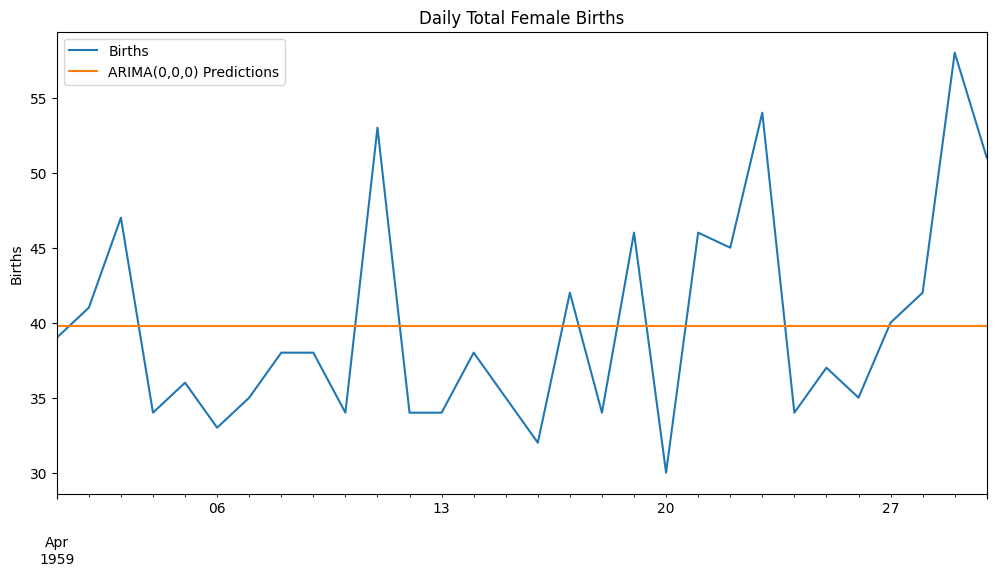

In [24]:
title = 'Daily Total Female Births'
ylabel='Births'
xlabel='' # we don't really need a label here

ax = test['Births'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [25]:
test.mean()

Births    39.833333
dtype: float64

In [26]:
predictions.mean()

39.78332832909347

Since our starting dataset exhibited no trend or seasonal component, this prediction makes sense. This actually shows the forecasted average value. In the next section we'll take additional steps to evaluate the performance of our predictions, and forecast into the future.

___
## Autoregressive Integrated Moving Average - ARIMA(p,d,q)
The steps are the same as for ARMA(p,q), except that we'll apply a differencing component to make the dataset stationary.<br>
First let's take a look at the <em>Real Manufacturing and Trade Inventories</em> dataset.
### Plot the Source Data

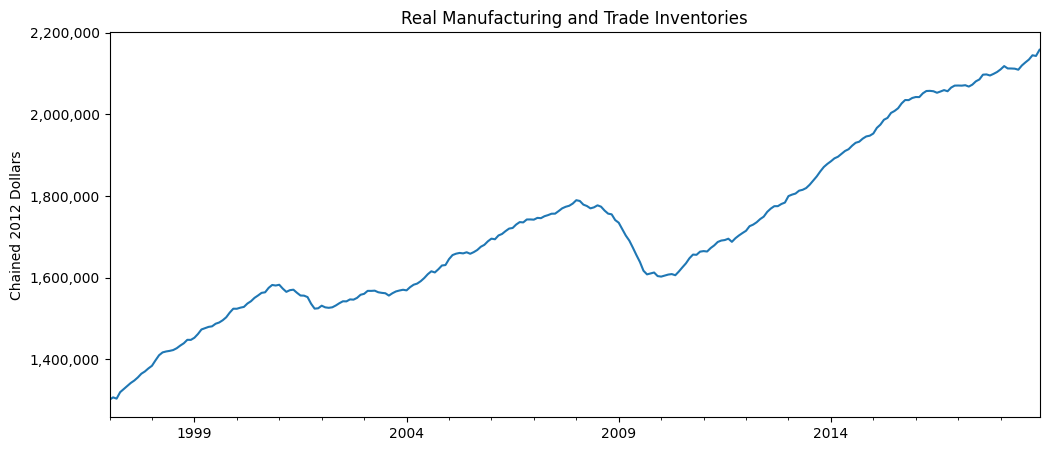

In [27]:
# HERE'S A TRICK TO ADD COMMAS TO Y-AXIS TICK VALUES
import matplotlib.ticker as ticker
formatter = ticker.StrMethodFormatter('{x:,.0f}')

title = 'Real Manufacturing and Trade Inventories'
ylabel='Chained 2012 Dollars'
xlabel='' # we don't really need a label here

ax = df2['Inventories'].plot(figsize=(12,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

### Run an ETS Decomposition (optional)
We probably won't learn a lot from it, but it never hurts to run an ETS Decomposition plot.

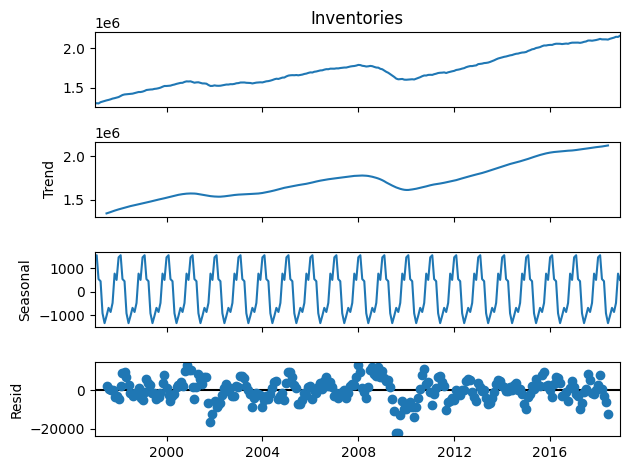

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df2['Inventories'], model='additive')  # model='add' also works
result.plot();

Here we see that the seasonal component does not contribute significantly to the behavior of the series.
### Use <tt>pmdarima.auto_arima</tt> to determine ARIMA Orders

In [34]:
model = auto_arima(df2['Inventories'],seasonal=False)

In [35]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  264
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2672.018
Date:                Fri, 04 Oct 2024   AIC                           5348.037
Time:                        09:22:12   BIC                           5355.181
Sample:                    01-01-1997   HQIC                          5350.908
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3258.3802    470.991      6.918      0.000    2335.255    4181.506
sigma2       3.91e+07   2.95e+06     13.250      0.000    3.33e+07    4.49e+07
===================================================================================
Ljung-Box (L1) (Q):                  82.61   Jarque-Bera (JB):               100.74
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -1.15
Prob(H) (two-sided):                  0.48   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
# Extract p, d, q from the fitted model
p, d, q = model.order
print(f"AR (p): {p}, Differencing (d): {d}, MA (q): {q}")

AR (p): 0, Differencing (d): 1, MA (q): 0


This suggests that we should fit an ARIMA(1,1,1) model to best forecast future values of the series. Before we train the model, let's look at augmented Dickey-Fuller Test, and the ACF/PACF plots to see if they agree. These steps are optional, and we would likely skip them in practice.

### Run the augmented Dickey-Fuller Test on the First Difference

In [31]:
from statsmodels.tsa.statespace.tools import diff
df2['d1'] = diff(df2['Inventories'],k_diff=1)

# Equivalent to:
# df1['d1'] = df1['Inventories'] - df1['Inventories'].shift(1)

adf_test(df2['d1'],'Real Manufacturing and Trade Inventories')

Augmented Dickey-Fuller Test: Real Manufacturing and Trade Inventories
ADF test statistic       -3.412249
p-value                   0.010548
# lags used               4.000000
# observations          258.000000
critical value (1%)      -3.455953
critical value (5%)      -2.872809
critical value (10%)     -2.572775
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


This confirms that we reached stationarity after the first difference.
### Run the ACF and PACF plots
A <strong>PACF Plot</strong> can reveal recommended AR(p) orders, and an <strong>ACF Plot</strong> can do the same for MA(q) orders.<br>
Alternatively, we can compare the stepwise <a href='https://en.wikipedia.org/wiki/Akaike_information_criterion'>Akaike Information Criterion (AIC)</a> values across a set of different (p,q) combinations to choose the best combination.

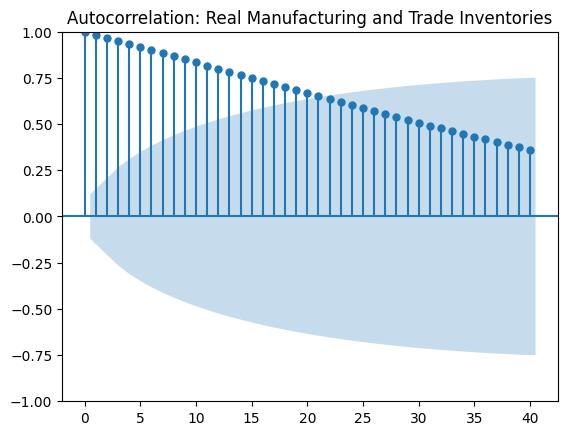

In [32]:
title = 'Autocorrelation: Real Manufacturing and Trade Inventories'
lags = 40
plot_acf(df2['Inventories'],title=title,lags=lags);

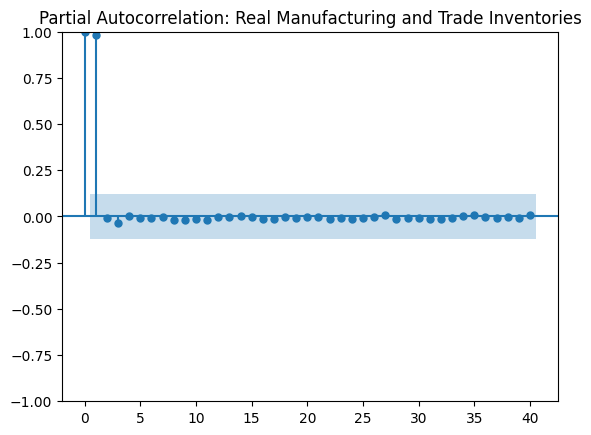

In [33]:
title = 'Partial Autocorrelation: Real Manufacturing and Trade Inventories'
lags = 40
plot_pacf(df2['Inventories'],title=title,lags=lags);

This tells us that the AR component should be more important than MA. From the <a href='https://people.duke.edu/~rnau/411arim3.htm'>Duke University Statistical Forecasting site</a>:<br>
> <em>If the PACF displays a sharp cutoff while the ACF decays more slowly (i.e., has significant spikes at higher lags), we    say that the stationarized series displays an "AR signature," meaning that the autocorrelation pattern can be explained more    easily by adding AR terms than by adding MA terms.</em><br>

Let's take a look at <tt>pmdarima.auto_arima</tt> done stepwise to see if having $p$ and $q$ terms the same still makes sense:

In [38]:
stepwise_fit = auto_arima(df2['Inventories'], start_p=0, start_q=0,
                          max_p=2, max_q=2, m=12,
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5348.037, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5399.843, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5350.241, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5409.217, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5378.835, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.113 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  264
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2672.018
Date:                Fri, 04 Oct 2024   AIC                           5348.037
Time:                        09:26:56   BIC                           5355.181
Sample:                    01-01-1997   HQIC                          5350.908
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3258.3802    470.991      6.918      0.000    2335.255    4181.506
sigma2       3.91e+07   2.95e+06     13.250      0.000    3.33e+07    4.49e+07
===================================================================================
Ljung-Box (L1) (Q):                  82.61   Jarque-Bera (JB):               100.74
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -1.15
Prob(H) (two-sided):                  0.48   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Looks good from here! Now let's train & test the ARIMA(1,1,1) model, evaluate it, then produce a forecast of future values.
### Split the data into train/test sets

In [71]:
len(df2)

264

In [72]:
# Set one year for testing
train = df2.iloc[:252]
test = df2.iloc[252:]

### Fit an ARIMA(0,1,0) Model

In [87]:
model = auto_arima(train['Inventories'], start_p=0, start_q=0,
                          max_p=2, max_q=2, m=12,
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5104.106, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5161.824, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5106.670, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5160.434, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5138.497, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.100 seconds


p: Number of autoregressive terms.
d: Degree of differencing (number of times the series has been differenced).
q: Number of moving average terms.
P: Seasonal autoregressive terms (if applicable).
D: Seasonal differencing (if applicable).
Q: Seasonal moving average terms (if applicable).
[s]: Seasonal period (if applicable).

In [90]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
# when d != 0, we need to choose typ= 'level' to return the predictions on the orignal data instead of differenced data
predictions = model.predict(n_periods=12, index=test.index).rename('ARIMA(0,1,0) Predictions') #typ=level will return back the original data not differenced data

In [91]:
print(f"Length of predictions: {len(predictions)}")
print(f"Length of test set: {len(test)}")

Length of predictions: 12
Length of test set: 12


Passing <tt>dynamic=False</tt> means that forecasts at each point are generated using the full history up to that point (all lagged values).

Passing <tt>typ='levels'</tt> predicts the levels of the original endogenous variables. If we'd used the default <tt>typ='linear'</tt> we would have seen linear predictions in terms of the differenced endogenous variables.

For more information on these arguments visit https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMAResults.predict.html

In [92]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test['Inventories'][i]}")

predicted=2106948.57 , expected=2110158
predicted=2110146.139, expected=2118199
predicted=2113343.709, expected=2112427
predicted=2116541.279, expected=2112276
predicted=2119738.849, expected=2111835
predicted=2122936.418, expected=2109298
predicted=2126133.988, expected=2119618
predicted=2129331.558, expected=2127170
predicted=2132529.127, expected=2134172
predicted=2135726.697, expected=2144639
predicted=2138924.267, expected=2143001
predicted=2142121.837, expected=2158115


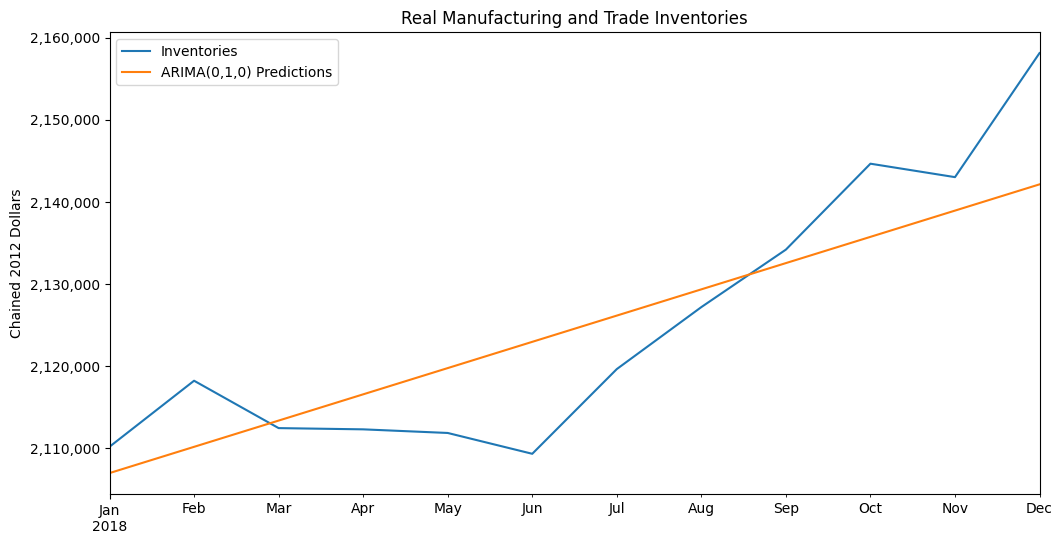

In [93]:
# Plot predictions against known values
title = 'Real Manufacturing and Trade Inventories'
ylabel='Chained 2012 Dollars'
xlabel='' # we don't really need a label here

ax = test['Inventories'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

### Evaluate the Model

In [94]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['Inventories'], predictions)
print(f'ARIMA(0,1,0) MSE Error: {error:11.10}')

ARIMA(0,1,0) MSE Error:  62026572.7


In [95]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['Inventories'], predictions)
print(f'ARIMA(0,1,0) RMSE Error: {error:11.10}')

ARIMA(0,1,0) RMSE Error: 7875.695061


### Retrain the model on the full data, and forecast the future

In [106]:
model = auto_arima(df2['Inventories'], start_p=0, start_q=0,
                          max_p=2, max_q=2, m=12,
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise
fcast = model.predict(n_periods=12).rename('ARIMA(0,1,0) Forecast')

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5348.037, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5399.843, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5350.241, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5409.217, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5378.835, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.096 seconds


In [104]:
predicted_values, conf_int = fcast
print("Predicted Values:", predicted_values)
print("Confidence Intervals:\n", conf_int)

Predicted Values: 2019-01-01    2.161373e+06
2019-02-01    2.164632e+06
2019-03-01    2.167890e+06
2019-04-01    2.171149e+06
2019-05-01    2.174407e+06
2019-06-01    2.177665e+06
2019-07-01    2.180924e+06
2019-08-01    2.184182e+06
2019-09-01    2.187440e+06
2019-10-01    2.190699e+06
2019-11-01    2.193957e+06
2019-12-01    2.197216e+06
Freq: MS, dtype: float64
Confidence Intervals:
 [[2149117.59464582 2173629.16581045]
 [2147299.46226823 2181964.05864432]
 [2146662.49736917 2189117.78399965]
 [2146636.94974792 2195660.09207717]
 [2147002.13146097 2201811.6708204 ]
 [2147644.86029519 2207685.70244245]
 [2148497.90082442 2213349.42236949]
 [2149517.445449   2218846.63820118]
 [2150673.06530629 2224207.77880017]
 [2151942.6053266  2229454.99923613]
 [2153309.34022192 2234605.02479709]
 [2154760.27610716 2239670.84936812]]


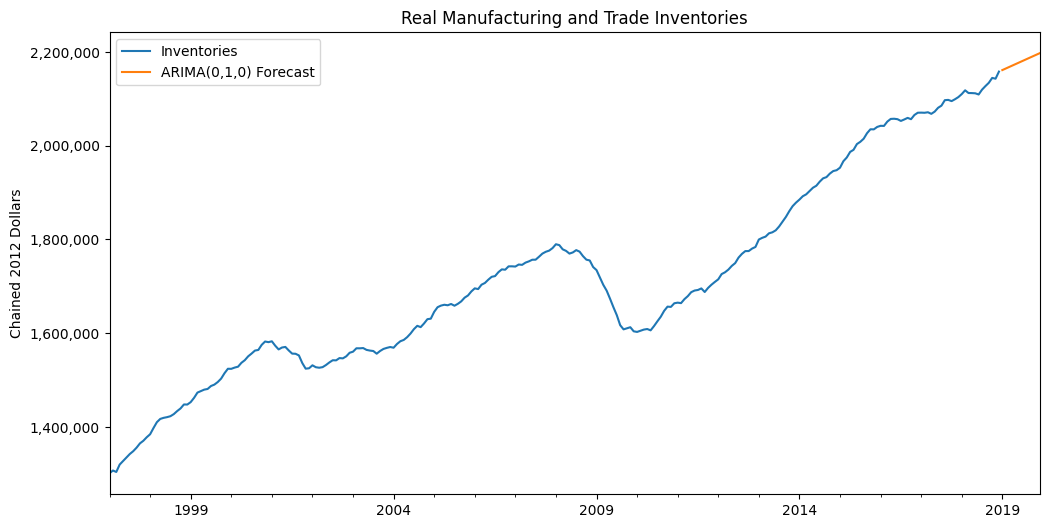

In [107]:
# Plot predictions against known values
title = 'Real Manufacturing and Trade Inventories'
ylabel='Chained 2012 Dollars'
xlabel='' # we don't really need a label here

ax = df2['Inventories'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

## Great job!